In [0]:
database = "boogaloo-capstone-human-life"
tableLE_All="dbo.Model_Data"
user = "bglcap"
password  = "48Gheq0Iz9t"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

In [0]:
Model_Data=spark.read.format("jdbc").option("url", f"jdbc:sqlserver://{server}:1433;databaseName={database};") \
    .option("dbtable", tableLE_All) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .load()


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [0]:
#Drop to "Female" column, change scaling of "Median Household Income", and split the independent and dependent variables

LE_restricted_Data_pandas=Model_Data[["Male","White","Black or African American","American Indian and Alaska Native","Asian","Native Hawaiian and other Pacific Islander","Other","Multiracial","Hispanic or Latino","Median Household Income","Percent Insured","Life Expectancy"]].toPandas()
LE_restricted_Data_pandas["Median Household Income"]=LE_restricted_Data_pandas["Median Household Income"]/100000.0

LE_restricted_dep=LE_restricted_Data_pandas["Life Expectancy"]
LE_restricted_ind=LE_restricted_Data_pandas.drop(columns={"Life Expectancy"},inplace=False)


In [0]:
#Standardize the Data

ss = StandardScaler()
zscore_restricted = ss.fit_transform(LE_restricted_ind)
LE_restricted_ind_normalized = pd.DataFrame(zscore_restricted, columns=LE_restricted_ind.columns.tolist())


In [0]:
#Splitting the data for model creation and testing
X1_train, X1_test, y1_train, y1_test = train_test_split(LE_restricted_ind_normalized, LE_restricted_dep,random_state=42)


In [0]:
#Linear Regression Model
normal_lin_reg = LinearRegression().fit(X1_train, y1_train)
print(normal_lin_reg.score(X1_test,y1_test))
print(normal_lin_reg.intercept_)
coefficient_matrix=pd.DataFrame()
coefficient_matrix["Variables"]=X1_test.columns
coefficient_matrix["Coefficients"]=normal_lin_reg.coef_
display(coefficient_matrix)
normal_lin_reg_predictions=normal_lin_reg.predict(X1_test)

0.7260036777525408
78.19569414368509

Variables,Coefficients
Male,0.13133494025268516
White,0.1281162495206598
Black or African American,-0.36365517480916254
American Indian and Alaska Native,-0.1584682729412803
Asian,0.7366582829167178
Native Hawaiian and other Pacific Islander,-0.02749778012202004
Other,-0.052957899852673296
Multiracial,-0.5206292042922207
Hispanic or Latino,0.3411263909397446
Median Household Income,0.9106874742106199


Looking at the coefficients the largest in magnitude are Asian, Multiracial, and Median Household Income.  As this data is all standardized, this seems
to indicate that these factors would have greater impact on the end result prediction.
Since this prediction model only has an R-squared value of .726, it isn't horrible, but is definitly not a very good predictor overall.

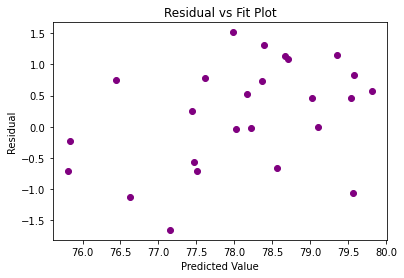

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
# sns.set_theme(style="darkgrid", palette='pastel')

ax_lr1=plt.scatter(normal_lin_reg_predictions,y1_test-normal_lin_reg_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

From this residual plot we see what could be random scatter which doesn't seem to have a large overall trend, though as there aren't
a lot of datapoints it is difficult to know if this reflects model reasonableness or if there just isn't enough data to notice some other trend

In [0]:
svr = SVR().fit(X1_train, y1_train)
svr_predictions=svr.predict(X1_test)
print(svr.score(X1_test,y1_test))

0.7871715109222475

This default SVM model already has a higher R-squared value than the basic linear regression, up to .787, we shall examine a residual plot to check for emergant trends

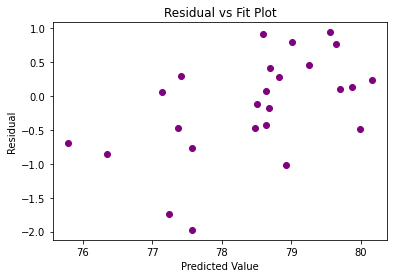

In [0]:
ax_svr1=plt.scatter(svr_predictions,y1_test-svr_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

It seems from this residual plot that there seems to be a missing trend in the model as the residuals seem to be positively correlated with the predicted value, though because of the small sample size this could simply be sampling error or a result of an underfit model.

In [0]:
svr_restricted_param_grid = {'C': [ 10,11,12,13,14,15], 
              'gamma': [.1,.15,.2,.25,.3,.35],
              'kernel': ['rbf'],
              'epsilon':[.1,.15,.2,.25,.3]}   
ml = svm.SVR()
svr_restricted_grid = GridSearchCV(ml, svr_restricted_param_grid, refit = True, verbose = 1,cv=5)
  
# fitting the model for grid search
svr_tuned=svr_restricted_grid.fit(X1_train, y1_train)

print(svr_tuned.best_params_)
svr_tuned_predictions=svr_tuned.predict(X1_test)
print(svr_tuned.score(X1_test,y1_test))


Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'C': 14, 'epsilon': 0.1, 'gamma': 0.35, 'kernel': 'rbf'}
0.9413530123906004

After some hyperparameter tuning we were able to get an R-squared value of .941, much better than the .726 of the Linear Regression and the .787 of the default SVR model.  While .941 is much better, it is still likely underfit due to lack of data.  To see if any other trends exist we shall examine a residual plot

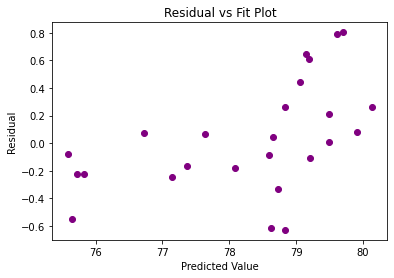

In [0]:
ax_svrt1=plt.scatter(svr_tuned_predictions,y1_test-svr_tuned_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

The first thing to note is that the magnitudes of the residuals for this model are generally lower, with the range from about (-.6,.8) as opposed to (-1.5,1.5) for Linear Regression or (-2,1) for the default SVR.  That being said, it appears the positive correlation between the residuals and the predictions seen in the default SVR has persisted to this model, though to a lesser degree, and the magnitude of the residuals also seems to be growing as the predicted value increases.  While this model scores better, and doesn't get as far off as the other two, it appears it could still be improved upon.

In [0]:
print(LE_restricted_Data_pandas.corr()["Life Expectancy"])

Male 0.300603
White -0.024882
Black or African American -0.464772
American Indian and Alaska Native -0.075283
Asian 0.456682
Native Hawaiian and other Pacific Islander 0.248467
Other 0.379231
Multiracial 0.282104
Hispanic or Latino 0.310126
Median Household Income 0.765060
Percent Insured 0.405851
Life Expectancy 1.000000
Name: Life Expectancy, dtype: float64

This column of the correlation matrix for the data our previous model was built on shows a rather strong positive correlation between "Median Household Income" and "Life Expectancy".  We thought it would be interesting to remove this column, and that of "Percent Insured", to see what possible effects that would have on our model.

In [0]:
#Dropping non demographic columns and "Female", splitting independent and dependent variables, normalize the data, and split the data for training
LE_demographic_Data_pandas=Model_Data[["Male","White","Black or African American","American Indian and Alaska Native","Asian","Native Hawaiian and other Pacific Islander","Other","Multiracial","Hispanic or Latino","Life Expectancy"]].toPandas()
LE_demographic_dep=LE_demographic_Data_pandas["Life Expectancy"]
LE_demographic_ind=LE_demographic_Data_pandas.drop(columns={"Life Expectancy"},inplace=False)

zscore_demographic = ss.fit_transform(LE_demographic_ind)
LE_demographic_ind_normalized = pd.DataFrame(zscore_demographic, columns=LE_demographic_ind.columns.tolist())

X2_train, X2_test, y2_train, y2_test = train_test_split(LE_demographic_ind_normalized, LE_demographic_dep,random_state=42)

In [0]:
#Linear Regression for Demographic Model
demographic_lin_reg = LinearRegression().fit(X2_train, y2_train)
print(demographic_lin_reg.score(X2_test,y2_test))
print(demographic_lin_reg.intercept_)
coefficient_matrix=pd.DataFrame()
coefficient_matrix["Variables"]=X2_test.columns
coefficient_matrix["Coefficients"]=demographic_lin_reg.coef_
display(coefficient_matrix)
demographic_lin_reg_predictions=demographic_lin_reg.predict(X2_test)

0.5076457108306489
78.19105338762797

Variables,Coefficients
Male,0.33655810393909513
White,-0.10564221699129481
Black or African American,-0.7172863558827921
American Indian and Alaska Native,-0.18887279070823315
Asian,2.4285568725248807
Native Hawaiian and other Pacific Islander,-1.3331309573185495
Other,-0.3226704317369515
Multiracial,-0.6686622579383215
Hispanic or Latino,0.21271765968253822


Right away we see that without the two columns from the previous model we get a worse R-squared value of .508 compared to the .726 from before.  This would seem to indicate that our model was indeed largely impacted by the existance of the columns removed.  We see also that once again the percent of the population which is Asian has a large positive impact on the overall health, while the percent Native Hawaiian and other Pacific Islander seems to have the largest negative impact, as opposed to "Multiracial" from the previous model.

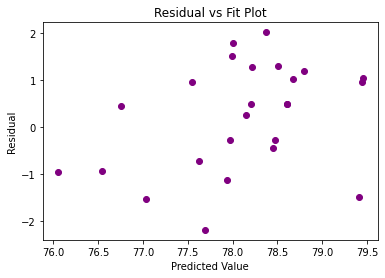

In [0]:
ax_lr2=plt.scatter(demographic_lin_reg_predictions,y2_test-demographic_lin_reg_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

While this does look fairly like random scatter, the magnitude of the residuals seem to be greater, going from (-1.5,1.5) to (-2,2).  There may be an unaccounted for trend, but this may also just be the same underfitting issue do to small sample size.

In [0]:
demographic_svr = SVR().fit(X2_train, y2_train)
demographic_svr_predictions=demographic_svr.predict(X2_test)
print(demographic_svr.score(X2_test,y2_test))


0.5336648846945675

Again, the default SVR model preforms slightly better on the data than the Linear Regression (.534 to .508), but still much worse than on the previous dataset (.787).

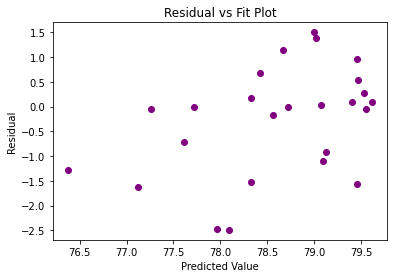

In [0]:
ax_svr2=plt.scatter(demographic_svr_predictions,y2_test-demographic_svr_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

As with the previous dataset we see a similar range of residuals (~4) when compared to the linear regression but the interval is again centered below 0, (-2.5,1.5).  Also as before it appears as if a positive correlation exists between the residuals and the predicted values, which is once again cause for minor concern, though could just be formed from underfitting due to small sampling size.

In [0]:

svr_demographic_param_grid = {'C': [ 10,11,12,13,14,15], 
              'gamma': [.2,.25,.3,.35,.4,.45,.5],
              'kernel': ['rbf'],
              'epsilon':[.1,.15,.2,.25,.3]}   
svr_demographic_grid = GridSearchCV(ml, svr_demographic_param_grid, refit = True, verbose = 1,cv=5)
  
# fitting the model for grid search
demographic_svr_tuned=svr_demographic_grid.fit(X2_train, y2_train)
print(demographic_svr_tuned.best_params_)
demographic_svr_tuned_predictions=demographic_svr_tuned.predict(X2_test)
print(demographic_svr_tuned.score(X2_test,y2_test))


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
{'C': 15, 'epsilon': 0.2, 'gamma': 0.5, 'kernel': 'rbf'}
0.8789368226819579

With some hyperparameter tuning this SVR model is much improved, .879 compared to .534, but still lags a bit behind the model built using the previous dataset (.941).

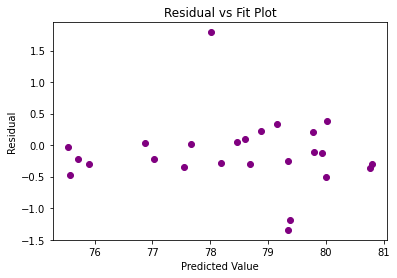

In [0]:
ax_svrt2=plt.scatter(demographic_svr_tuned_predictions,y2_test-demographic_svr_tuned_predictions,c='purple')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual vs Fit Plot")
plt.show()

Here we see a very interesting Residual Plot as it almost looks to be very good, most of the data is in an interval about (-.5,.5), but with 3 drastic outliers (further than .5 from the general grouping).  This could be caused by the small sample size and a particularly lucky (or unlucky) random sampling, the best way to improve it is likely adding more data, but this seems to indicate that while it previously appeared the model was very reliant on the removed data that may not actually be the case.

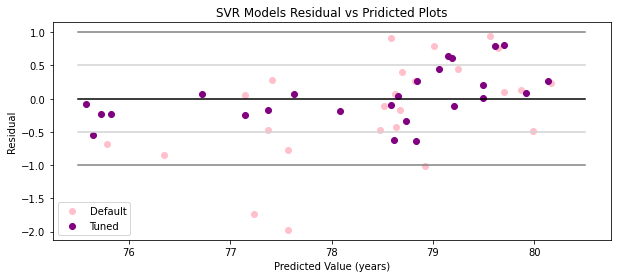

In [0]:
fig = plt.figure(facecolor="white",figsize=(10, 4))
ax = fig.gca()
ax.scatter(svr_predictions,y1_test-svr_predictions,color='pink',label="Default")
ax.scatter(svr_tuned_predictions,y1_test-svr_tuned_predictions,color='purple',label="Tuned")

ax.plot([75.5, 80.5], [0, 0],color="black")
ax.plot([75.5, 80.5], [1, 1],color="grey")
ax.plot([75.5, 80.5], [-1, -1],color="grey")
ax.plot([75.5, 80.5], [.5, .5],color="lightgrey")
ax.plot([75.5, 80.5], [-.5, -.5],color="lightgrey")
plt.xlabel("Predicted Value (years)")
plt.ylabel("Residual")
plt.title("SVR Models Residual vs Pridicted Plots")
plt.legend()
plt.show()


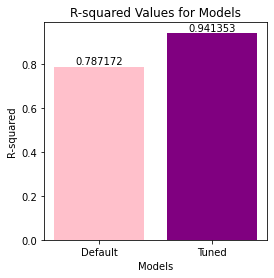

In [0]:
from sklearn.metrics import r2_score
SVR_R_squared = r2_score(y1_test,svr_predictions)
SVR_tuned_R_squared=r2_score(y1_test,svr_tuned_predictions)
fig = plt.figure(facecolor="white",figsize=(4, 4))
ax = fig.gca()
bar_1=ax.bar(["Default"],SVR_R_squared,color=['pink'])
bar_2=ax.bar(["Tuned"],SVR_tuned_R_squared,color=['purple'])
ax.bar_label(bar_1)
ax.bar_label(bar_2)
plt.xlabel("Models")
plt.ylabel("R-squared")
plt.title("R-squared Values for Models")
plt.show()

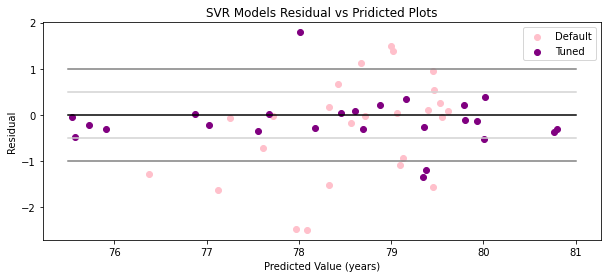

In [0]:
fig = plt.figure(facecolor="white",figsize=(10, 4))
ax = fig.gca()
ax.scatter(demographic_svr_predictions,y2_test-demographic_svr_predictions,color='pink',label="Default")
ax.scatter(demographic_svr_tuned_predictions,y2_test-demographic_svr_tuned_predictions,color='purple',label="Tuned")

ax.plot([75.5, 81], [0, 0],color="black")
ax.plot([75.5, 81], [1, 1],color="grey")
ax.plot([75.5, 81], [-1, -1],color="grey")
ax.plot([75.5, 81], [.5, .5],color="lightgrey")
ax.plot([75.5, 81], [-.5, -.5],color="lightgrey")
plt.xlabel("Predicted Value (years)")
plt.ylabel("Residual")
plt.title("SVR Models Residual vs Pridicted Plots")
plt.legend()
plt.show()

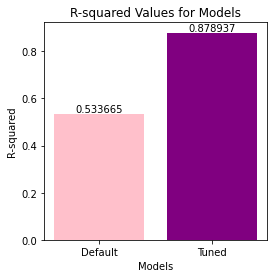

In [0]:
SVR_R_squared = r2_score(y2_test,demographic_svr_predictions)
SVR_tuned_R_squared=r2_score(y2_test,demographic_svr_tuned_predictions)
fig = plt.figure(facecolor="white",figsize=(4, 4))
ax = fig.gca()
bar_1=ax.bar(["Default"],SVR_R_squared,color=['pink'])
bar_2=ax.bar(["Tuned"],SVR_tuned_R_squared,color=['purple'])
ax.bar_label(bar_1)
ax.bar_label(bar_2)
plt.xlabel("Models")
plt.ylabel("R-squared")
plt.title("R-squared Values for Models")
plt.show()